In [1]:
import os
import sys
from pathlib import Path
import pathlib
import tensorflow as tf


import cv2
import time

from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('../utils')

from object_detection.utils import label_map_util

from find_vehicle_locations import find_detections_and_centroid_in_image, \
           find_detections_in_image,find_detections_in_array_of_images, get_model, get_keras_model

### Input Path to Test Data and Models

In [2]:
# Path to Test Data
# test_image_locations='../workspace/gta_project/test'
test_image_locations='../data/sample_test_images'
# Name of Bounding Box Detection Model
DETECT_MODEL_NAME ='three_class_resnet50_v1_fpn_120821'
# Classification Model Name
CLASSIFICSTION_MODEL_NAME ='ResNet50_RegionModel_10PercValAnd5Test_200Batch_3classes'

saveImage = False


#### Create Model Paths

In [3]:
# Path to Exported Detection Model
PATH_TO_DETECT_MODEL_DIR = f'../workspace/gta_project/exported-models/{DETECT_MODEL_NAME}'

# Path to Exported Classification Model
PATH_TO_CLASS_MODEL_DIR = f'../workspace/gta_project/exported-models/{CLASSIFICSTION_MODEL_NAME}'

# Path to Image Label Map
PATH_TO_LABELS = f'../workspace/gta_project/exported-models/{DETECT_MODEL_NAME}/label_map.pbtxt'

#### Find All Images in Test Image Directory

In [4]:
all_image_file_paths = np.array([file_path for file_path in Path(test_image_locations).glob('**/*.jpg')])

N = len(all_image_file_paths)

print(f'There are {N} test images.')

There are 5 test images.


#### Load Category Index and Models

In [5]:
# Load in Category Index if You Have it
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,use_display_name=True)

In [6]:
# Load saved Detection and Classification Models
detect_fn = get_model(PATH_TO_DETECT_MODEL_DIR)

class_fn = get_keras_model(PATH_TO_CLASS_MODEL_DIR)

Loading model...Done! Took 33.45935797691345 seconds
Loading keras model ...Done! Took 25.553313970565796 seconds


#### Run Inference

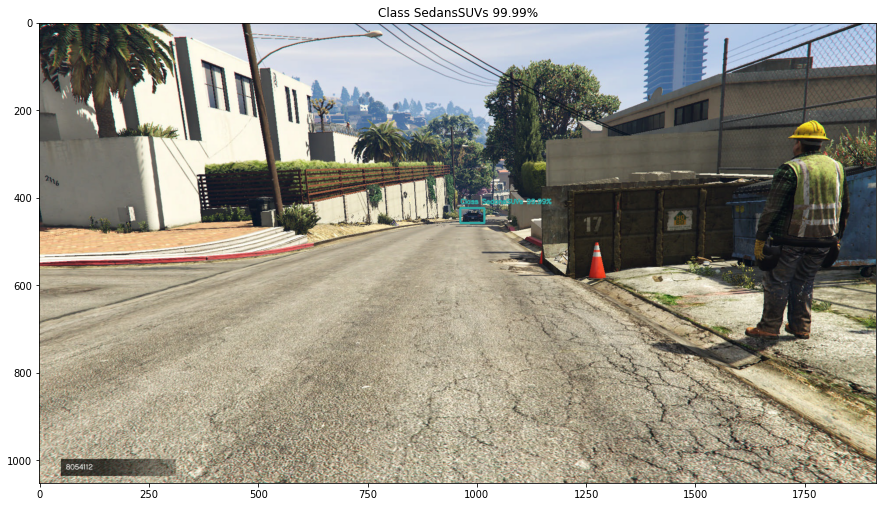

In [7]:
# Get Random Image from Test Files
i_rand = np.random.randint(N)

imageFileLocation = all_image_file_paths[i_rand]

find_detections_in_image(imageFileLocation,detect_fn,class_model=class_fn,category_index=category_index,saveFile=False)

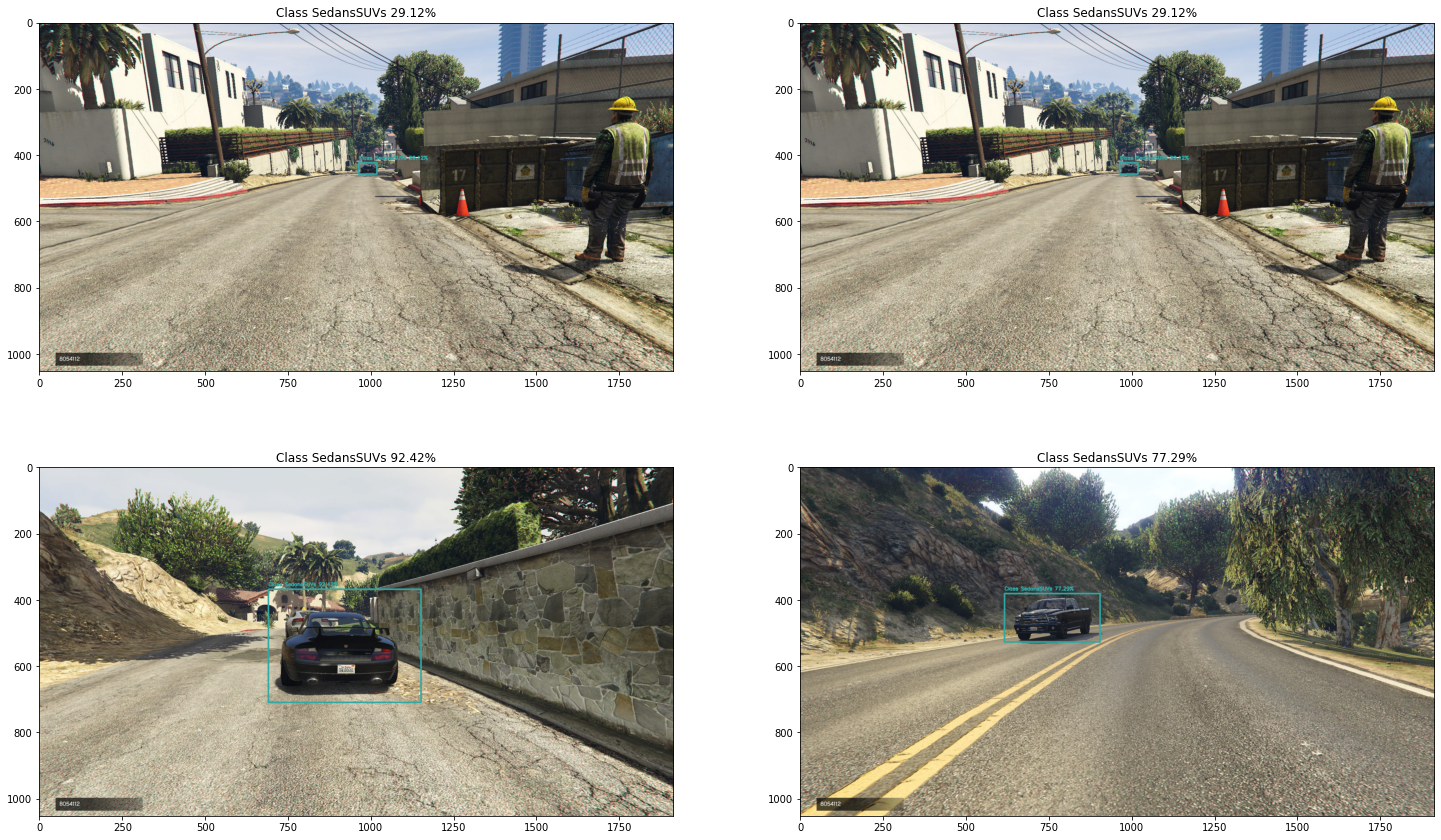

In [8]:
# Get Random Image from Test Files
i_rand = np.random.randint(N,None,4)

imageFileLocations = all_image_file_paths[i_rand]

find_detections_in_array_of_images(imageFileLocations,detect_fn,category_index=category_index,grid_x=2)

#### Project Lidar into Image Plane

Class IndustrialTrucksCycles 60.15%


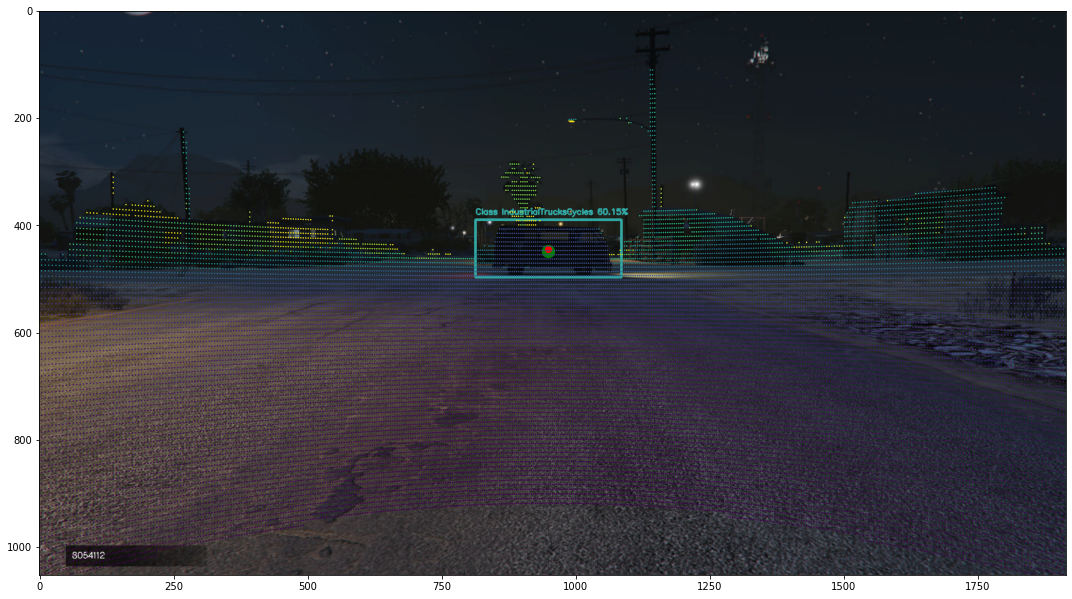

In [9]:
# Get Random Image from Test Files
i_rand = np.random.randint(N)
imageFileLocation = str(all_image_file_paths[i_rand])


xyz = np.fromfile(imageFileLocation.replace('_image.jpg', '_cloud.bin'), dtype=np.float32)
xyz = xyz.reshape([3, -1])

proj = np.fromfile(imageFileLocation.replace('_image.jpg', '_proj.bin'), dtype=np.float32)
proj.resize([3, 4])

# Lidar Points in Pixels 
uv = proj @ np.vstack([xyz, np.ones_like(xyz[0, :])])
uv = uv / uv[2, :]

dist = np.linalg.norm(xyz, axis=0)


# Get Centroid
image, cent_x, cent_y = find_detections_and_centroid_in_image(imageFileLocation,detect_fn,category_index=category_index)

centroid = np.array([cent_x, cent_y,1])

idx_centroid = np.argmin(np.linalg.norm(uv - centroid[:,None],axis=0))
lidar_centroid = xyz[:,idx_centroid]

uv_lidar_c = np.dot(proj, np.append(lidar_centroid,1))
uv_lidar_c = uv_lidar_c / uv_lidar_c[2]

# Plot Lidar Onto Image

plt.figure(figsize=(15,10))
plt.imshow(image)

plt.scatter([uv_lidar_c[0]],[uv_lidar_c[1]],color='green',s=150)
plt.scatter([cent_x],[cent_y],color='red') 

plt.scatter(uv[0,:],uv[1,:], c=dist, marker='.', s=1) 

plt.tight_layout()

if saveImage:
    fileName = f"{Path(imageFileLocation).stem}_boxed.jpg"
    plt.savefig(fileName)


plt.show()

